<a href="https://colab.research.google.com/github/Rays-Uddin/used-car-price-prediction/blob/main/model_hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Importing required libraries and dataset

In [ ]:
# Importing libraries
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns

In [ ]:
# Read dataset
df = pd.read_csv('used_cars_preprocessed.csv', usecols=["brand", "model", "model_year", "engine_type", "fuel_type", "mileage in miles", "damage", "price_usd"])
df.sample(5)

,brand,model,model_year,engine_type,fuel_type,mileage in miles,damage,price_usd
1048,Nissan,Armada Platinum,2018,NaN,Gasoline,108206,Damage reported,26498
3417,Tesla,Model S 100D,2018,NaN,NaN,83424,None reported,45000
1054,Chevrolet,limited_model,2015,V8,Diesel,77500,None reported,54000
3760,Chevrolet,Silverado 1500 ZR2,2022,V8,Gasoline,7455,None reported,68990
3793,Toyota,4Runner Limited,2014,V6,Gasoline,65000,None reported,27999


In [ ]:
# dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3998 entries, 0 to 3997
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   brand             3998 non-null   object
 1   model             3998 non-null   object
 2   model_year        3998 non-null   int64 
 3   engine_type       3617 non-null   object
 4   fuel_type         3828 non-null   object
 5   mileage in miles  3998 non-null   int64 
 6   damage            3885 non-null   object
 7   price_usd         3998 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 250.0+ KB


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import os
import json

In [ ]:
# Divide data into X (independent) and y (target) variables
X = df.drop(columns=["price_usd"])
y = np.log(df["price_usd"])

In [ ]:
# Splitting the dataset to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.21, random_state=123, stratify=X['model'])

In [ ]:
# Train and test data shape
print(f"X_train, X_test shape: {X_train.shape, X_test.shape}")
print(f"y_train, y_test shape: {y_train.shape, y_test.shape}")

X_train, X_test shape: ((3158, 7), (840, 7))
y_train, y_test shape: ((3158,), (840,))


# 2. Defining custom class transformer

In [ ]:
class OrderedTargetEncoder(BaseEstimator, TransformerMixin):
    """
    A custom transformer for ordered target encoding of categorical features.

    This encoder replaces categorical values with their smoothed target means,
    and then maps these smoothed means to an ordered integer sequence.
    It handles unknown categories by imputing with the global mean or raising an error.

    Attributes:
        columns (list): List of column names to encode. If None, all object-type columns are encoded.
        smoothing (float): Smoothing factor for target mean calculation. Higher values reduce the impact of small categories.
        handle_unknown (str): Strategy to handle unknown categories during transform.
                              'mean': Imputes unknown categories with the mean order of known categories.
                              'error': Raises a ValueError if unknown categories are encountered.
        encodings_ (dict): Stores the smoothed target means for each category in each column.
        global_mean_ (float): The overall mean of the target variable.
        mapping_order_ (dict): Stores the ordered integer mapping for each category in each column.
    """

    def __init__(self, columns=None, smoothing=1.0, handle_unknown="mean"):
        """
        Initializes the OrderedTargetEncoder.

        Args:
            columns (list, optional): List of column names to encode. If None, all object-type columns are encoded.
                                      Defaults to None.
            smoothing (float, optional): Smoothing factor for target mean calculation. Defaults to 1.0.
            handle_unknown (str, optional): Strategy to handle unknown categories ('mean' or 'error').
                                            Defaults to "mean".
        """
        self.columns = columns
        self.smoothing = smoothing
        self.handle_unknown = handle_unknown
        self.encodings_ = {}
        self.global_mean_ = None
        self.mapping_order_ = {}

    def fit(self, X, y):
        """
        Fits the encoder to the training data.

        Calculates the global mean of the target and smoothed target means for each category
        in the specified columns. It then creates an ordered integer mapping based on these smoothed means.

        Args:
            X (pd.DataFrame or np.ndarray): The input features (training data).
            y (pd.Series or np.ndarray): The target variable.

        Returns:
            self (OrderedTargetEncoder): The fitted encoder instance.
        """

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.columns or [f'col_{i}' for i in range(X.shape[1])])

        y = pd.Series(y, name="target")


        if self.columns is None:
            self.columns = X.columns

        self.global_mean_ = y.mean()


        for col in self.columns:
            df_temp = pd.concat([X[col], y], axis=1)

            stats = df_temp.groupby(col)["target"].agg(["mean", "count"])

            smoothing_factor = stats["count"] / (stats["count"] + self.smoothing)
            stats["smoothed_mean"] = smoothing_factor * stats["mean"] + (1-smoothing_factor) * self.global_mean_

            stats = stats.sort_values(by = "smoothed_mean")

            ordered_map = {category: i for i, category in enumerate(stats.index)}

            self.encodings_[col] = stats["smoothed_mean"].to_dict()

            self.mapping_order_[col] = ordered_map

        return self

    def transform(self, X):
        """
        Transforms the input features using the fitted encoder.

        Replaces categorical values with their corresponding ordered integer from the mapping.
        Handles unknown categories based on the `handle_unknown` strategy.

        Args:
            X (pd.DataFrame or np.ndarray): The input features to transform.

        Returns:
            pd.DataFrame: The transformed features with ordered integer encoded columns.

        Raises:
            ValueError: If `handle_unknown` is 'error' and unknown categories are encountered.
        """

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.columns)

        X_encoded = X.copy()

        for col in self.columns:

            X_encoded[col] = X_encoded[col].map(self.mapping_order_[col])

            if X_encoded[col].isnull().any() and self.handle_unknown == "mean":

                mean_order = np.mean(list(self.mapping_order_[col].values()))
                X_encoded[col] = X_encoded[col].fillna(mean_order)

            elif X_encoded[col].isnull().any() and self.handle_unknown == "error":
                raise ValueError(f"Unknown categories encountered in column {col} and handle_unknown is set to 'error'.")

        return X_encoded

# 3. Hyperparameter Tuning

## 3.1. Linear Regression

In [ ]:
# Pipeline for One-Hot Encoding categorical features
ohe_pipe = Pipeline(steps = [
    ('ohe', OneHotEncoder(sparse_output = False, drop = 'first'))
])

# Pipeline for Ordered Target Encoding the 'model' feature, imputing unseen values, and scaling
ote_pipe = Pipeline(steps = [
    ('ote', OrderedTargetEncoder()),
    ('scaler', StandardScaler())
])

# Pipeline for imputing missing 'fuel_type' and then One-Hot Encoding
fuel_pipe = Pipeline(steps = [
    ('nan_fuel', SimpleImputer(strategy='constant', fill_value='Electric')),
    ('ohe_fuel', OneHotEncoder(sparse_output = False, drop = 'first'))
])

# Pipeline for imputing missing 'damage' and then One-Hot Encoding
damage_pipe = Pipeline(steps = [
    ('nan_damage', SimpleImputer(strategy='most_frequent')),
    ('ohe_damage', OneHotEncoder(sparse_output = False, drop = 'first'))
])

# Pipeline for imputing numerical features, applying polynomial features, and scaling
poly_pipe = Pipeline(steps=[
    ("poly", PolynomialFeatures()),
    ('scaler', StandardScaler())
])

# ColumnTransformer to apply different preprocessing steps to different columns
preprocessor_lr = ColumnTransformer(transformers = [
    ('ohe_pipe', ohe_pipe, ['brand', 'engine_type']),
    ('ote_pipe', ote_pipe, ['model']),
    ('fuel_pipe', fuel_pipe, ['fuel_type']),
    ('damage_pipe', damage_pipe, ['damage']),
    ('poly_pipe', poly_pipe, ['model_year', 'mileage in miles']),
], remainder = 'passthrough')

In [ ]:
# Setup and run GridSearchCV for Linear Regression model
pipe_lr = Pipeline([
    ('preprocessor_lr', preprocessor_lr),
    ('regressor_lr', LinearRegression())
])

param_grid_lr = {
    'preprocessor_lr__ote_pipe__ote__smoothing': np.arange(0.1, 3, 0.3),
    'preprocessor_lr__poly_pipe__poly__degree': [1, 2, 3],
    'preprocessor_lr__poly_pipe__poly__include_bias': [False, True]
}

gs_lr = GridSearchCV(
    estimator=pipe_lr,
    param_grid=param_grid_lr,
    cv=5,
    scoring='r2',
    n_jobs=-1
    )

gs_lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor_lr',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe_pipe',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse_output=False))]),
                                                                         ['brand',
                                                                          'engine_type']),
                                                                        ('ote_pipe',
                                                                         Pipeline(steps=[('ote',
                                                                                          OrderedTargetEncoder()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['model']),
                                                                        ('fuel_pipe',
                                                                         Pipelin...
                                                                                          PolynomialFeatures()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['model_year',
                                                                          'mileage '
                                                                          'in '
                                                                          'miles'])])),
                                       ('regressor_lr', LinearRegression())]),
             n_jobs=-1,
             param_grid={'preprocessor_lr__ote_pipe__ote__smoothing': array([0.1, 0.4, 0.7, 1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8]),
                         'preprocessor_lr__poly_pipe__poly__degree': [1, 2, 3],
                         'preprocessor_lr__poly_pipe__poly__include_bias': [False,
                                                                            True]},
             scoring='r2')

In [ ]:
# Display best parameters and evaluation metrics for Linear Regression
best_parameters_lr = gs_lr.best_params_
model_lr = gs_lr.best_estimator_
r2_gs_lr = gs_lr.best_score_

# Predictions
y_pred_lr = model_lr.predict(X_test)

# Residuals
resid_lr = y_test - y_pred_lr

# Performance metrics
r_squared_lr = r2_score(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)

print(f"Best parameters from Grid Search CV: {best_parameters_lr}")
print(f"Mean Absolute Error: {mae_lr:.3f}, Mean Squared Error: {mse_lr:.3f}, R squared grid search: {r2_gs_lr:.3f}, R squared prediction: {r_squared_lr:.3f}")

Best parameters from Grid Search CV: {'preprocessor_lr__ote_pipe__ote__smoothing': np.float64(0.7000000000000001), 'preprocessor_lr__poly_pipe__poly__degree': 3, 'preprocessor_lr__poly_pipe__poly__include_bias': True}
Mean Absolute Error: 0.250, Mean Squared Error: 0.112, R squared grid search: 0.809, R squared prediction: 0.828


In [ ]:
# Saving best parameters of linear regression model to json
params = {}

params['Linear Regression'] = {
    'best_value': r2_gs_lr,
    'best_params': best_parameters_lr
    }

with open('best_params.json', 'w') as f:
    json.dump(params, f, indent=4)

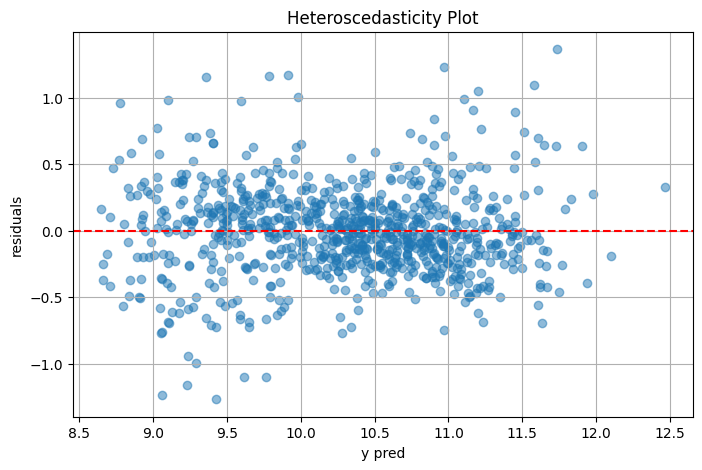

In [ ]:
# Heteroscedasticity plot
plt.figure(figsize=(8,5))
plt.scatter(y_pred_lr, resid_lr, alpha=0.5)
plt.xlabel("y pred")
plt.ylabel("residuals")
plt.title("Heteroscedasticity Plot")
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

The plot shows the residuals are spread randomly or uniformly around the zero horizontal red dotted line, this indicates homoscedasticity.

# 4. Hyperparameter tuning using optuna

In [ ]:
# Installing the Optuna library for hyperparameter optimization.
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 12.3 MB/s eta 0:00:00


In [ ]:
# Importing the Optuna library and its visualization tools.
import optuna
from optuna.visualization import plot_optimization_history, plot_slice, plot_param_importances

## 4.1. Regularized Linear Model
### Ridge, Lasso and Elastic Net

In [ ]:
def objective_regularize(trial):

    '''
    This function defines the objective for Optuna to optimize for regularized linear models.
    It includes preprocessing steps and hyperparameter suggestions for Ridge, Lasso, and ElasticNet.
    '''
    # OrderedTarget Encoder parameters
    smoothing = trial.suggest_float('smoothing', 0.0, 3.0)
    ote = OrderedTargetEncoder(smoothing=smoothing)

    # Polynomial parameters
    degree = trial.suggest_int('degree', 1, 3)
    include_bias = trial.suggest_categorical('include_bias', [False, True])
    poly = PolynomialFeatures(
        degree=degree, include_bias=include_bias
    )

    # Preprocessor pipelines and column tramsformer
    ohe_pipe = Pipeline(steps = [
        ('ohe', OneHotEncoder(sparse_output = False, drop = 'first'))
    ])

    encoder_pipe = Pipeline(steps = [
        ('ote', ote),
        ('scaler', StandardScaler())
    ])

    engine_pipe = Pipeline([
        ('impute_unknown', SimpleImputer(strategy='constant', fill_value='unknown/electric')),
        ('ohe_engine', OneHotEncoder(sparse_output = False, drop = 'first'))
    ])

    fuel_pipe = Pipeline(steps = [
        ('nan_fuel', SimpleImputer(strategy='constant', fill_value='Electric')),
        ('ohe_fuel', OneHotEncoder(sparse_output = False, drop = 'first'))
    ])

    damage_pipe = Pipeline(steps = [
        ('nan_damage', SimpleImputer(strategy='most_frequent')),
        ('ohe_damage', OneHotEncoder(sparse_output = False, drop = 'first'))
    ])

    poly_pipe = Pipeline(steps=[
        ("poly", poly),
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(transformers = [
        ('ohe_pipe', ohe_pipe, ['brand']),
        ('encoder_pipe', encoder_pipe, ['model']),
        ('engine_pipe', engine_pipe, ['engine_type']),
        ('fuel_pipe', fuel_pipe, ['fuel_type']),
        ('damage_pipe', damage_pipe, ['damage']),
        ('poly_pipe', poly_pipe, ['model_year', 'mileage in miles']),
    ], remainder = 'passthrough')


    # Regularization selection
    regressor = trial.suggest_categorical('regressor', ['Ridge', 'Lasso', 'ElasticNet'])

    # Ridge
    if regressor == 'Ridge':

      ridge_params = {
        'alpha': trial.suggest_float('ridge_alpha', 1e-4, 10.0, log=True),
        'fit_intercept': trial.suggest_categorical('ridge_fit_intercept', [False, True]),
        'max_iter': trial.suggest_int('ridge_max_iter', 1000, 50000),
        'tol': trial.suggest_float('ridge_tol', 1e-6, 1e-1, log=True),
        'solver': trial.suggest_categorical('ridge_solver', ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'])
      }

      model = Ridge(**ridge_params, random_state=32)

    # Lasso
    elif regressor == 'Lasso':

      lasso_params = {
        'alpha': trial.suggest_float('lasso_alpha', 1e-4, 10.0, log=True),
        'max_iter': trial.suggest_int('lasso_max_iter', 1000, 50000),
        'tol': trial.suggest_float('lasso_tol', 1e-6, 1e-1, log=True),
        'fit_intercept': trial.suggest_categorical('lasso_fit_intercept', [False, True]),
        'selection': trial.suggest_categorical('lasso_selection', ['cyclic', 'random'])
      }

      model = Lasso(**lasso_params, random_state=35)

    # ElasticNet
    elif regressor == 'ElasticNet':

      elasticnet_params = {
        'alpha': trial.suggest_float('elasticnet_alpha', 1e-4, 10.0, log=True),
        'max_iter': trial.suggest_int('elasticnet_max_iter', 1000, 50000),
        'tol': trial.suggest_float('elasticnet_tol', 1e-6, 1e-1, log=True),
        'l1_ratio': trial.suggest_float('elasticnet_l1_ratio', 0.2, 0.9),
        'fit_intercept': trial.suggest_categorical('elasticnet_fit_intercept', [False, True])
      }

      model = ElasticNet(**elasticnet_params, random_state=37)


    # Final preprocessor and model pipeline
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # Cross validation
    score = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2').mean()

    return score

In [ ]:
# Optuna optimization for regularized linear models.
study_regularize = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=39))
study_regularize.optimize(objective_regularize, n_trials=70, show_progress_bar=True)

[I 2026-01-20 08:28:17,579] A new study created in memory with name: no-name-0c378fff-8fda-40b0-b929-438358fc0758


  0%|          | 0/70 [00:00<?, ?it/s]

[I 2026-01-20 08:28:17,872] Trial 0 finished with value: 0.7074868693621809 and parameters: {'smoothing': 1.6406674684360643, 'degree': 3, 'include_bias': False, 'regressor': 'Ridge', 'ridge_alpha': 0.0227629593129393, 'ridge_fit_intercept': True, 'ridge_max_iter': 40960, 'ridge_tol': 0.05274833575620632, 'ridge_solver': 'lsqr'}. Best is trial 0 with value: 0.7074868693621809.
[I 2026-01-20 08:28:18,147] Trial 1 finished with value: -5.9766844169219775 and parameters: {'smoothing': 2.5812114332187144, 'degree': 1, 'include_bias': False, 'regressor': 'ElasticNet', 'elasticnet_alpha': 0.10290955970106236, 'elasticnet_max_iter': 8700, 'elasticnet_tol': 0.00042708196914853925, 'elasticnet_l1_ratio': 0.3313180679170991, 'elasticnet_fit_intercept': False}. Best is trial 0 with value: 0.7074868693621809.
[I 2026-01-20 08:28:18,479] Trial 2 finished with value: -0.0006117305207387514 and parameters: {'smoothing': 0.46927771214877867, 'degree': 3, 'include_bias': True, 'regressor': 'Lasso', 'la

In [ ]:
# Best R2 score and parameters found by the Optuna study for regularized linear models.
print(study_regularize.best_trial.value)
study_regularize.best_trial.params

0.7955301547659153


{'smoothing': 1.7068384237648162,
 'degree': 2,
 'include_bias': True,
 'regressor': 'ElasticNet',
 'elasticnet_alpha': 0.00010314357812369284,
 'elasticnet_max_iter': 31402,
 'elasticnet_tol': 0.0011493103348685228,
 'elasticnet_l1_ratio': 0.7938115698383685,
 'elasticnet_fit_intercept': True}

In [ ]:
# Display the optimization history plot from the Optuna study.
plot_optimization_history(study_regularize).show()

In [ ]:
# Display slice plots for the hyperparameters from the Optuna study.
plot_slice(study_regularize).show()

In [ ]:
# Display the hyperparameter importances plot from the Optuna study.
plot_param_importances(study_regularize).show()

## 4.2. K Neighbor Regressor

In [ ]:
def objective_knn(trial):

    '''
    This function defines the objective for Optuna to optimize for the K-Neighbors Regressor.
    '''

    # OTE parameters
    smoothing = trial.suggest_float('smoothing', 0, 3)
    ote = OrderedTargetEncoder(smoothing=smoothing)


    # Polynomial parameters
    degree = trial.suggest_int('degree', 1, 3)
    include_bias = trial.suggest_categorical('include_bias', [False, True])
    poly = PolynomialFeatures(
        degree=degree, include_bias=include_bias
    )

    # Preprocessor pipelines and column tramsformer
    ohe_pipe = Pipeline(steps = [
        ('ohe', OneHotEncoder(sparse_output = False, drop = 'first'))
    ])

    ote_pipe = Pipeline(steps = [
        ('ote', ote),
        ('scaler', StandardScaler())
    ])

    engine_pipe = Pipeline([
        ('impute_unknown', SimpleImputer(strategy='constant', fill_value='unknown/electric')),
        ('ohe_engine', OneHotEncoder(sparse_output = False, drop = 'first'))
    ])

    fuel_pipe = Pipeline(steps = [
        ('nan_fuel', SimpleImputer(strategy='constant', fill_value='Electric')),
        ('ohe_fuel', OneHotEncoder(sparse_output = False, drop = 'first'))
    ])

    damage_pipe = Pipeline(steps = [
        ('nan_damage', SimpleImputer(strategy='most_frequent')),
        ('ohe_damage', OneHotEncoder(sparse_output = False, drop = 'first'))
    ])

    poly_pipe = Pipeline(steps=[
        ("poly", poly),
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(transformers = [
        ('ohe_pipe', ohe_pipe, ['brand']),
        ('ote_pipe', ote_pipe, ['model']),
        ('engine_pipe', engine_pipe, ['engine_type']),
        ('fuel_pipe', fuel_pipe, ['fuel_type']),
        ('damage_pipe', damage_pipe, ['damage']),
        ('poly_pipe', poly_pipe, ['model_year', 'mileage in miles']),
    ], remainder = 'passthrough')


    # K-neighbor regressor hyperparameters
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 5, 30),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'algorithm': trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
        'metric': trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski']),
        'p': trial.suggest_int('p', 1, 2)
    }

    model = KNeighborsRegressor(**params, n_jobs=-1)

    # Final model and preprocessor pipeline
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    score = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2').mean()

    return score

In [ ]:
# Optuna optimization for K-Neighbors Regressor.
study_knn = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study_knn.optimize(objective_knn, n_trials=70, show_progress_bar=True)

[I 2026-01-20 08:29:37,050] A new study created in memory with name: no-name-283dd6c9-17fb-4cb5-bff5-9dbb31d1c9d3


  0%|          | 0/70 [00:00<?, ?it/s]

[I 2026-01-20 08:29:37,534] Trial 0 finished with value: 0.7969795162173029 and parameters: {'smoothing': 1.1236203565420875, 'degree': 3, 'include_bias': False, 'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean', 'p': 1}. Best is trial 0 with value: 0.7969795162173029.
[I 2026-01-20 08:29:38,497] Trial 1 finished with value: 0.7883737006485575 and parameters: {'smoothing': 0.5502135295603015, 'degree': 1, 'include_bias': False, 'n_neighbors': 12, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'minkowski', 'p': 1}. Best is trial 0 with value: 0.7969795162173029.
[I 2026-01-20 08:29:39,607] Trial 2 finished with value: 0.7737131244245341 and parameters: {'smoothing': 1.822634555704315, 'degree': 1, 'include_bias': True, 'n_neighbors': 30, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'p': 1}. Best is trial 0 with value: 0.7969795162173029.
[I 2026-01-20 08:29:40,574] Trial 3 finished with value: 0.7908778455526622 and param

In [ ]:
# best R2 score and parameters found by the Optuna study for K-Neighbors Regressor.
print(study_knn.best_trial.value)
study_knn.best_trial.params

0.8220521632597035


{'smoothing': 1.1027195458047556,
 'degree': 2,
 'include_bias': False,
 'n_neighbors': 8,
 'weights': 'distance',
 'algorithm': 'ball_tree',
 'metric': 'manhattan',
 'p': 2}

In [ ]:
# display the optimization history plot from the Optuna study for K-Neighbors Regressor.
plot_optimization_history(study_knn).show()

In [ ]:
# display slice plots for the K-Neighbors Regressor hyperparameters.
plot_slice(study_knn).show()

In [ ]:
# display the hyperparameter importances plot for K-Neighbors Regressor.
plot_param_importances(study_knn).show()

## 4.3 Support Vector Regreesion

In [ ]:
def objective_svr(trial):

    '''
    This function defines the objective for Optuna to optimize for the Support Vector Regressor (SVR).
    '''

    # OTE parameters
    smoothing = trial.suggest_float('smoothing', 0, 3)
    ote = OrderedTargetEncoder(smoothing=smoothing)

    # Preprocessor pipelines and column tramsformer
    ohe_pipe = Pipeline(steps = [
        ('ohe', OneHotEncoder(sparse_output = False, drop = 'first'))
    ])

    ote_pipe = Pipeline(steps = [
        ('ote', ote),
        ('scaler', StandardScaler())
    ])

    engine_pipe = Pipeline([
        ('impute_unknown', SimpleImputer(strategy='constant', fill_value='unknown/electric')),
        ('ohe_engine', OneHotEncoder(sparse_output = False, drop = 'first'))
    ])

    fuel_pipe = Pipeline(steps = [
        ('nan_fuel', SimpleImputer(strategy='constant', fill_value='Electric')),
        ('ohe_fuel', OneHotEncoder(sparse_output = False, drop = 'first'))
    ])

    damage_pipe = Pipeline(steps = [
        ('nan_damage', SimpleImputer(strategy='most_frequent')),
        ('ohe_damage', OneHotEncoder(sparse_output = False, drop = 'first'))
    ])

    scaler = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])


    preprocessor = ColumnTransformer(transformers = [
        ('ohe_pipe', ohe_pipe, ['brand']),
        ('ote_pipe', ote_pipe, ['model']),
        ('engine_pipe', engine_pipe, ['engine_type']),
        ('fuel_pipe', fuel_pipe, ['fuel_type']),
        ('damage_pipe', damage_pipe, ['damage']),
        ('scaler', scaler, ['model_year', 'mileage in miles'])
    ], remainder = 'passthrough')


    # SVR hyperparameters
    param = {
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'degree': trial.suggest_int('degree', 1, 3),
        'gamma': trial.suggest_float('gamma', 1e-3, 0.75, log = True),
        'tol': trial.suggest_float('tol', 1e-4, 1, log = True),
        'C': trial.suggest_float('C', 0.01, 50, log = True),
        'epsilon': trial.suggest_float('epsilon', 1e-3, 1)
    }

    svr = SVR(**param)


    # Final preprocessor and model pipeline
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', svr)
    ])

    ## Pruning
    # cross validation
    cv = KFold(n_splits=5, shuffle=True, random_state=111)
    scores = []

    # Manually iterate through folds for pruning
    for i, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
      #splitting data
      X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
      y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

      # fit and get score
      pipe.fit(X_fold_train, y_fold_train)
      fold_score = pipe.score(X_fold_val, y_fold_val)
      scores.append(fold_score)

      # report for intermediate result to optuna
      current_avg_score = np.mean(scores)
      trial.report(current_avg_score, i)

      # handle pruning to stop trial if it performs poorly
      if trial.should_prune():
          raise optuna.exceptions.TrialPruned()

    return np.mean(scores)


In [ ]:
# Optuna optimization for the Support Vector Regressor (SVR).
study_svr = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=43), pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=1, n_min_trials=2))
study_svr.optimize(objective_svr, n_trials=70, show_progress_bar=True)

[I 2026-01-20 08:30:27,644] A new study created in memory with name: no-name-c5369fab-4928-4350-9613-75dd487db118


  0%|          | 0/70 [00:00<?, ?it/s]

[I 2026-01-20 08:30:28,022] Trial 0 finished with value: 0.7003813824605694 and parameters: {'smoothing': 0.34516369916933687, 'kernel': 'linear', 'degree': 3, 'gamma': 0.08223376407226131, 'tol': 0.014609954019847438, 'C': 0.012803280675232285, 'epsilon': 0.7340145479840027}. Best is trial 0 with value: 0.7003813824605694.
[I 2026-01-20 08:30:28,730] Trial 1 finished with value: 0.4060614665922235 and parameters: {'smoothing': 1.1848500552930177, 'kernel': 'sigmoid', 'degree': 1, 'gamma': 0.01460055868306, 'tol': 0.0018381708896171767, 'C': 0.019212019896664396, 'epsilon': 0.8433814695354749}. Best is trial 0 with value: 0.7003813824605694.
[I 2026-01-20 08:30:29,514] Trial 2 finished with value: 0.7677027101671969 and parameters: {'smoothing': 2.5468174432345845, 'kernel': 'linear', 'degree': 3, 'gamma': 0.0017266038187569988, 'tol': 0.38760941718034425, 'C': 0.126562781320618, 'epsilon': 0.26304251777378507}. Best is trial 2 with value: 0.7677027101671969.
[I 2026-01-20 08:30:31,251

In [ ]:
# best R2 score and parameters found by the Optuna study for SVR.
print(study_svr.best_trial.value)
study_svr.best_trial.params

0.8411373750703831


{'smoothing': 0.4189992117346143,
 'kernel': 'rbf',
 'degree': 3,
 'gamma': 0.1096565189128103,
 'tol': 0.0930844377161945,
 'C': 3.620041916760818,
 'epsilon': 0.14954686584240706}

In [ ]:
# display the optimization history plot from the Optuna study for SVR.
plot_optimization_history(study_svr).show()

In [ ]:
# display slice plots for the SVR hyperparameters.
plot_slice(study_svr).show()

In [ ]:
# display the hyperparameter importances plot for SVR.
plot_param_importances(study_svr).show()

## 4.4 Regression Trees

### 4.4.1.Decision Tree

In [ ]:
def objective_dt(trial):

    '''
    This function defines the objective for Optuna to optimize for the Decision Tree Regressor.
    '''

    # OTE parameters
    smoothing = trial.suggest_float('smoothing', 0, 3)
    ote = OrderedTargetEncoder(smoothing=smoothing)

    # preprocessor pipelines and column transformer
    ohe_pipe = Pipeline(steps = [
        ('ohe', OneHotEncoder(sparse_output = False, drop = 'first'))
    ])

    ote_pipe = Pipeline(steps = [
        ('ote', ote)
    ])

    engine_pipe = Pipeline([
        ('impute_unknown', SimpleImputer(strategy='constant', fill_value='unknown/electric')),
        ('ohe_engine', OneHotEncoder(sparse_output = False, drop = 'first'))
    ])

    fuel_pipe = Pipeline(steps = [
        ('nan_fuel', SimpleImputer(strategy='constant', fill_value='Electric')),
        ('ohe_fuel', OneHotEncoder(sparse_output = False, drop = 'first'))
    ])

    damage_pipe = Pipeline(steps = [
        ('nan_damage', SimpleImputer(strategy='most_frequent')),
        ('ohe_damage', OneHotEncoder(sparse_output = False, drop = 'first'))
    ])


    preprocessor = ColumnTransformer(transformers = [
        ('ohe_pipe', ohe_pipe, ['brand']),
        ('ote_pipe', ote_pipe, ['model']),
        ('engine_pipe', engine_pipe, ['engine_type']),
        ('fuel_pipe', fuel_pipe, ['fuel_type']),
        ('damage_pipe', damage_pipe, ['damage']),
    ], remainder = 'passthrough')


      # Decision tree hyperparameters
    params = {
        'criterion': trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']),
        'max_depth': trial.suggest_categorical('max_depth', [8, 16, 32, 64, None]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 100),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 100),
        'max_features': trial.suggest_categorical('max_features', [0.33, 0.5, 0.75, None])
    }

    model = DecisionTreeRegressor(**params, random_state=45)

    # Final preprocessor and model pipeline
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # Pruning
    # Cross validation
    cv = KFold(n_splits=5, shuffle=True, random_state=138)
    scores = []

    # Manually iterate through folds for pruning
    for i, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
      #splitting data
      X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
      y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

      # fit and get score
      pipe.fit(X_fold_train, y_fold_train)
      fold_score = pipe.score(X_fold_val, y_fold_val)
      scores.append(fold_score)

      # report for intermediate result to optuna
      current_avg_score = np.mean(scores)
      trial.report(current_avg_score, i)

      # handle pruning to stop trial if it performs poorly
      if trial.should_prune():
          raise optuna.exceptions.TrialPruned()

    return np.mean(scores)


In [ ]:
# Optuna optimization for the Decision Tree Regressor.
study_dt = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=52), pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=1, n_min_trials=2))
study_dt.optimize(objective_dt, n_trials=70, show_progress_bar=True)

[I 2026-01-20 09:07:35,684] A new study created in memory with name: no-name-0edee9e6-9c34-42de-9a18-8f52c925764c


  0%|          | 0/70 [00:00<?, ?it/s]

[I 2026-01-20 09:07:36,786] Trial 0 finished with value: 0.6214042759224896 and parameters: {'smoothing': 2.469331022129376, 'criterion': 'absolute_error', 'max_depth': 64, 'min_samples_split': 65, 'min_samples_leaf': 77, 'max_features': 0.75}. Best is trial 0 with value: 0.6214042759224896.
[I 2026-01-20 09:07:38,252] Trial 1 finished with value: 0.6349919532797751 and parameters: {'smoothing': 2.7783107145804946, 'criterion': 'absolute_error', 'max_depth': 64, 'min_samples_split': 21, 'min_samples_leaf': 81, 'max_features': None}. Best is trial 1 with value: 0.6349919532797751.
[I 2026-01-20 09:07:38,593] Trial 2 finished with value: 0.6299653561745251 and parameters: {'smoothing': 1.3361324876730825, 'criterion': 'squared_error', 'max_depth': 16, 'min_samples_split': 51, 'min_samples_leaf': 86, 'max_features': 0.5}. Best is trial 1 with value: 0.6349919532797751.
[I 2026-01-20 09:07:38,954] Trial 3 finished with value: 0.6587093795808444 and parameters: {'smoothing': 2.3621558749103

In [ ]:
# best R2 score and parameters found by the Optuna study for Decision Tree Regressor.
print(study_dt.best_trial.value)
study_dt.best_trial.params

0.724338340323021


{'smoothing': 0.26729430080408323,
 'criterion': 'squared_error',
 'max_depth': None,
 'min_samples_split': 14,
 'min_samples_leaf': 6,
 'max_features': 0.75}

In [ ]:
# display the optimization history plot from the Optuna study for Decision Tree Regressor.
plot_optimization_history(study_dt).show()

In [ ]:
# display slice plots for the Decision Tree Regressor hyperparameters.
plot_slice(study_dt).show()

In [ ]:
# display the hyperparameter importances plot for Decision Tree Regressor.
plot_param_importances(study_dt).show()

### 4.4.2. Random Forest

In [ ]:
def objective_rf(trial):

    '''
    This function defines the objective for Optuna to optimize for the Random Forest Regressor.
    '''

    # OTE parameters
    smoothing = trial.suggest_float('smoothing', 0, 3)
    ote = OrderedTargetEncoder(smoothing=smoothing)

    # preprocessor pipeline and column transformer
    ohe_pipe = Pipeline(steps = [
        ('ohe', OneHotEncoder(sparse_output = False, drop = 'first'))
    ])

    ote_pipe = Pipeline(steps = [
        ('ote', ote)
    ])

    engine_pipe = Pipeline([
        ('impute_unknown', SimpleImputer(strategy='constant', fill_value='unknown/electric')),
        ('ohe_engine', OneHotEncoder(sparse_output = False, drop = 'first'))
    ])

    fuel_pipe = Pipeline(steps = [
        ('nan_fuel', SimpleImputer(strategy='constant', fill_value='Electric')),
        ('ohe_fuel', OneHotEncoder(sparse_output = False, drop = 'first'))
    ])

    damage_pipe = Pipeline(steps = [
        ('nan_damage', SimpleImputer(strategy='most_frequent')),
        ('ohe_damage', OneHotEncoder(sparse_output = False, drop = 'first'))
    ])


    preprocessor = ColumnTransformer(transformers = [
        ('ohe_pipe', ohe_pipe, ['brand']),
        ('ote_pipe', ote_pipe, ['model']),
        ('engine_pipe', engine_pipe, ['engine_type']),
        ('fuel_pipe', fuel_pipe, ['fuel_type']),
        ('damage_pipe', damage_pipe, ['damage']),
    ], remainder = 'passthrough')


    # Random forest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'criterion': trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']),
        'max_depth': trial.suggest_categorical('max_depth', [8, 16, 32, None]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
        'max_features': trial.suggest_categorical('max_features', [0.33, 0.5, 0.75, None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [False, True])
    }

    model = RandomForestRegressor(**params, n_jobs=-1, random_state=13)


    # Final pipeline
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # Pruning
    # Cross validation
    cv = KFold(n_splits=5, shuffle=True, random_state=142)
    scores = []

    # Manually iterate through folds for pruning
    for i, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
      #splitting data
      X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
      y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

      # fit and get score
      pipe.fit(X_fold_train, y_fold_train)
      fold_score = pipe.score(X_fold_val, y_fold_val)
      scores.append(fold_score)

      # report for intermediate result to optuna
      current_avg_score = np.mean(scores)
      trial.report(current_avg_score, i)

      # handle pruning to stop trial if it performs poorly
      if trial.should_prune():
          raise optuna.exceptions.TrialPruned()

    return np.mean(scores)

In [ ]:
# Optuna optimization for the Random Forest Regressor.
study_rf = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=57), pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=1, n_min_trials=2))
study_rf.optimize(objective_rf, n_trials=70, show_progress_bar=True)

[I 2026-01-20 09:15:45,410] A new study created in memory with name: no-name-08fdf8f4-f722-484c-aa05-75fb4c051cf1


  0%|          | 0/70 [00:00<?, ?it/s]

[I 2026-01-20 09:17:28,676] Trial 0 finished with value: 0.7404737975747715 and parameters: {'smoothing': 0.2620489287065252, 'n_estimators': 192, 'criterion': 'absolute_error', 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 45, 'max_features': 0.5, 'bootstrap': False}. Best is trial 0 with value: 0.7404737975747715.
[I 2026-01-20 09:19:30,084] Trial 1 finished with value: 0.7871243499940883 and parameters: {'smoothing': 2.7818636844066273, 'n_estimators': 164, 'criterion': 'absolute_error', 'max_depth': None, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 0.75, 'bootstrap': True}. Best is trial 1 with value: 0.7871243499940883.
[I 2026-01-20 09:19:38,010] Trial 2 finished with value: 0.7543125626257143 and parameters: {'smoothing': 2.019131598598212, 'n_estimators': 419, 'criterion': 'friedman_mse', 'max_depth': 8, 'min_samples_split': 26, 'min_samples_leaf': 14, 'max_features': 0.5, 'bootstrap': True}. Best is trial 1 with value: 0.7871243499940883.
[I 2

In [ ]:
# best R2 score and parameters found by the Optuna study for Random Forest Regressor.
print(study_rf.best_trial.value)
study_rf.best_trial.params

0.807279895257631


{'smoothing': 0.5048330599517759,
 'n_estimators': 233,
 'criterion': 'poisson',
 'max_depth': 32,
 'min_samples_split': 18,
 'min_samples_leaf': 1,
 'max_features': 0.33,
 'bootstrap': False}

In [ ]:
# display the optimization history plot from the Optuna study for Random Forest Regressor.
plot_optimization_history(study_rf).show()

In [ ]:
# display slice plots for the Random Forest Regressor hyperparameters.
plot_slice(study_rf).show()

In [ ]:
# displays the hyperparameter importances plot for Random Forest Regressor.
plot_param_importances(study_rf).show()

## 4.5. Boosting Ensemble

### 4.5.1. AdaBoost

In [ ]:
def objective_adaboost(trial):

    '''
    This function defines the objective for Optuna to optimize for the AdaBoost Regressor.
    '''

    # OTE parameters
    smoothing = trial.suggest_float('smoothing', 0, 3)
    ote = OrderedTargetEncoder(smoothing=smoothing)

    # preprocessor pipeline and colimn transformer
    ohe_pipe = Pipeline(steps = [
        ('ohe', OneHotEncoder(sparse_output = False, drop = 'first'))
    ])

    ote_pipe = Pipeline(steps = [
        ('ote', ote)
    ])

    engine_pipe = Pipeline([
        ('impute_unknown', SimpleImputer(strategy='constant', fill_value='unknown/electric')),
        ('ohe_engine', OneHotEncoder(sparse_output = False, drop = 'first'))
        ])

    fuel_pipe = Pipeline(steps = [
        ('nan_fuel', SimpleImputer(strategy='constant', fill_value='Electric')),
        ('ohe_fuel', OneHotEncoder(sparse_output = False, drop = 'first'))
    ])

    damage_pipe = Pipeline(steps = [
        ('nan_damage', SimpleImputer(strategy='most_frequent')),
        ('ohe_damage', OneHotEncoder(sparse_output = False, drop = 'first'))
    ])


    preprocessor = ColumnTransformer(transformers = [
        ('ohe_pipe', ohe_pipe, ['brand']),
        ('ote_pipe', ote_pipe, ['model']),
        ('engine_pipe', engine_pipe, ['engine_type']),
        ('fuel_pipe', fuel_pipe, ['fuel_type']),
        ('damage_pipe', damage_pipe, ['damage'])
    ], remainder = 'passthrough')


    # Adaptive boosting hyperparameters
    tree_params = {
    'max_depth': trial.suggest_int('max_depth', 1, 5),
    'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
    }
    estimator = DecisionTreeRegressor(**tree_params, random_state=22)

    params = {
        'loss': trial.suggest_categorical('loss', ['linear', 'square', 'exponential']),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1, log = True)
    }


    model = AdaBoostRegressor(estimator = estimator, **params, random_state=63)

    # Final pipeline
    pipe= Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # Pruning
    # Cross validation
    cv = KFold(n_splits=5, shuffle=True, random_state=153)
    scores = []

    # Manually iterate through folds for pruning
    for i, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
      #splitting data
      X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
      y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

      # fit and get score
      pipe.fit(X_fold_train, y_fold_train)
      fold_score = pipe.score(X_fold_val, y_fold_val)
      scores.append(fold_score)

      # report for intermediate result to optuna
      current_avg_score = np.mean(scores)
      trial.report(current_avg_score, i)

      # handle pruning to stop trial if it performs poorly
      if trial.should_prune():
          raise optuna.exceptions.TrialPruned()

    return np.mean(scores)

In [ ]:
# Optuna optimization for the AdaBoost Regressor.
study_adaboost = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=68), pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=1, n_min_trials=2))
study_adaboost.optimize(objective_adaboost, n_trials=70, show_progress_bar=True)

[I 2026-01-20 09:57:45,983] A new study created in memory with name: no-name-9eaa4ab0-af84-476a-a70f-e6e9f113c285


  0%|          | 0/70 [00:00<?, ?it/s]

[I 2026-01-20 09:57:48,883] Trial 0 finished with value: 0.5015304376895188 and parameters: {'smoothing': 0.7781144098453302, 'max_depth': 1, 'min_samples_split': 30, 'min_samples_leaf': 6, 'loss': 'exponential', 'n_estimators': 138, 'learning_rate': 0.12597985999975458}. Best is trial 0 with value: 0.5015304376895188.
[I 2026-01-20 09:58:05,449] Trial 1 finished with value: 0.7220517989820892 and parameters: {'smoothing': 2.798688069201765, 'max_depth': 5, 'min_samples_split': 41, 'min_samples_leaf': 49, 'loss': 'exponential', 'n_estimators': 411, 'learning_rate': 0.05911090375779926}. Best is trial 1 with value: 0.7220517989820892.
[I 2026-01-20 09:58:08,935] Trial 2 finished with value: 0.505360314675582 and parameters: {'smoothing': 0.5066341280475072, 'max_depth': 1, 'min_samples_split': 3, 'min_samples_leaf': 12, 'loss': 'square', 'n_estimators': 136, 'learning_rate': 0.9055316930571083}. Best is trial 1 with value: 0.7220517989820892.
[I 2026-01-20 09:58:12,319] Trial 3 finished

In [ ]:
# best R2 score and parameters found by the Optuna study for AdaBoost Regressor.
print(study_adaboost.best_trial.value)
study_adaboost.best_trial.params

0.7587273182281615


{'smoothing': 0.3790486564403904,
 'max_depth': 5,
 'min_samples_split': 6,
 'min_samples_leaf': 2,
 'loss': 'exponential',
 'n_estimators': 485,
 'learning_rate': 0.13696229292058906}

In [ ]:
# display the optimization history plot from the Optuna study for AdaBoost Regressor.
plot_optimization_history(study_adaboost).show()

In [ ]:
# display slice plots for the AdaBoost Regressor hyperparameters.
plot_slice(study_adaboost).show()

In [ ]:
# display the hyperparameter importances plot for AdaBoost Regressor.
plot_param_importances(study_adaboost).show()

### 4.5.2. GradientBoost

In [ ]:
def objective_gradboost(trial):

    '''
    This function defines the objective for Optuna to optimize for the Gradient Boosting Regressor.
    '''

    # OTE parameters
    smoothing = trial.suggest_float('smoothing', 0, 3)
    ote = OrderedTargetEncoder(smoothing=smoothing)

    # preprocessor pipelines and column transformer
    ohe_pipe = Pipeline(steps = [
        ('ohe', OneHotEncoder(sparse_output = False, drop = 'first'))
    ])

    ote_pipe = Pipeline(steps = [
        ('ote', ote)
    ])

    engine_pipe = Pipeline([
        ('impute_unknown', SimpleImputer(strategy='constant', fill_value='unknown/electric')),
        ('ohe_engine', OneHotEncoder(sparse_output = False, drop = 'first'))
        ])

    fuel_pipe = Pipeline(steps = [
        ('nan_fuel', SimpleImputer(strategy='constant', fill_value='Electric')),
        ('ohe_fuel', OneHotEncoder(sparse_output = False, drop = 'first'))
    ])

    damage_pipe = Pipeline(steps = [
        ('nan_damage', SimpleImputer(strategy='most_frequent')),
        ('ohe_damage', OneHotEncoder(sparse_output = False, drop = 'first'))
    ])


    preprocessor = ColumnTransformer(transformers = [
        ('ohe_pipe', ohe_pipe, ['brand']),
        ('ote_pipe', ote_pipe, ['model']),
        ('engine_pipe', engine_pipe, ['engine_type']),
        ('fuel_pipe', fuel_pipe, ['fuel_type']),
        ('damage_pipe', damage_pipe, ['damage'])
    ], remainder = 'passthrough')


    # Gradient boosting hyperparameters
    params = {
        'criterion': trial.suggest_categorical('criterion', ['friedman_mse', 'squared_error']),
        'loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error', 'huber', 'quantile']),
        'n_estimators': trial.suggest_int('n_estimators', 50, 700),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
        'max_features': trial.suggest_categorical('max_features', [0.5, 0.75, None])
    }

    model = GradientBoostingRegressor(**params, random_state=72)


    pipe= Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # Pruning
    # Cross validation
    cv = KFold(n_splits=5, shuffle=True, random_state=159)
    scores = []

    # Manually iterate through folds for pruning
    for i, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
      #splitting data
      X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
      y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

      # fit and get score
      pipe.fit(X_fold_train, y_fold_train)
      fold_score = pipe.score(X_fold_val, y_fold_val)
      scores.append(fold_score)

      # report for intermediate result to optuna
      current_avg_score = np.mean(scores)
      trial.report(current_avg_score, i)

      # handle pruning to stop trial if it performs poorly
      if trial.should_prune():
          raise optuna.exceptions.TrialPruned()

    return np.mean(scores)

In [ ]:
# Optuna optimization for the Gradient Boosting Regressor.
study_gradboost = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=75), pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=1, n_min_trials=2))
study_gradboost.optimize(objective_gradboost, n_trials=70, show_progress_bar=True)

[I 2026-01-20 10:13:19,664] A new study created in memory with name: no-name-74192064-869f-4170-bbd5-780d9a8137db


  0%|          | 0/70 [00:00<?, ?it/s]

[I 2026-01-20 10:13:31,389] Trial 0 finished with value: 0.6960169930565311 and parameters: {'smoothing': 1.706820660357737, 'criterion': 'squared_error', 'loss': 'squared_error', 'n_estimators': 452, 'learning_rate': 0.0031369751150138164, 'max_depth': 10, 'min_samples_split': 33, 'min_samples_leaf': 34, 'max_features': 0.5}. Best is trial 0 with value: 0.6960169930565311.
[I 2026-01-20 10:13:51,701] Trial 1 finished with value: 0.2695224826607217 and parameters: {'smoothing': 0.7675030531366902, 'criterion': 'friedman_mse', 'loss': 'huber', 'n_estimators': 193, 'learning_rate': 0.0012996062982820326, 'max_depth': 8, 'min_samples_split': 50, 'min_samples_leaf': 39, 'max_features': 0.75}. Best is trial 0 with value: 0.6960169930565311.
[I 2026-01-20 10:14:23,117] Trial 2 finished with value: 0.7592533621157356 and parameters: {'smoothing': 0.6301958190490964, 'criterion': 'squared_error', 'loss': 'squared_error', 'n_estimators': 619, 'learning_rate': 0.6589991175651637, 'max_depth': 8,

In [ ]:
# best R2 score and parameters found by the Optuna study for Gradient Boosting Regressor.
print(study_gradboost.best_trial.value)
print(study_gradboost.best_trial.params)

0.8237892041658395
{'smoothing': 2.3584257396096926, 'criterion': 'squared_error', 'loss': 'squared_error', 'n_estimators': 629, 'learning_rate': 0.12287168689166578, 'max_depth': 5, 'min_samples_split': 50, 'min_samples_leaf': 7, 'max_features': 0.5}


In [ ]:
# display the optimization history plot from the Optuna study for Gradient Boosting Regressor.
plot_optimization_history(study_gradboost).show()

In [ ]:
# display slice plots for the Gradient Boosting Regressor hyperparameters.
plot_slice(study_gradboost).show()

In [ ]:
# display the hyperparameter importances plot for Gradient Boosting Regressor.
plot_param_importances(study_gradboost).show()

## 4.6. XGB Regressor

In [ ]:
def objective_xgb(trial):

    '''
    This function defines the objective for Optuna to optimize for the XGBoost Regressor.
    '''

    # OTE parameters
    smoothing = trial.suggest_float('smoothing', 0, 3)
    ote = OrderedTargetEncoder(smoothing=smoothing)

    ohe_pipe = Pipeline(steps = [
        ('ohe', OneHotEncoder(sparse_output = False))
    ])

    ote_pipe = Pipeline(steps = [
        ('ote', ote)
    ])

    engine_pipe = Pipeline([
        ('impute_unknown', SimpleImputer(strategy='constant', fill_value='unknown/electric')),
        ('ohe_engine', OneHotEncoder(sparse_output = False))
    ])

    fuel_pipe = Pipeline(steps = [
        ('nan_fuel', SimpleImputer(strategy='constant', fill_value='Electric')),
        ('ohe_fuel', OneHotEncoder(sparse_output = False))
    ])

    damage_pipe = Pipeline(steps = [
        ('nan_damage', SimpleImputer(strategy='most_frequent')),
        ('ohe_damage', OneHotEncoder(sparse_output = False))
    ])


    preprocessor = ColumnTransformer(transformers = [
        ('ohe_pipe', ohe_pipe, ['brand']),
        ('ote_pipe', ote_pipe, ['model']),
        ('engine_pipe', engine_pipe, ['engine_type']),
        ('fuel_pipe', fuel_pipe, ['fuel_type']),
        ('damage_pipe', damage_pipe, ['damage'])
    ], remainder = 'passthrough')


    # XGB Regressor parameters
    params = {
        'booster': trial.suggest_categorical('booster', ['gbtree']),
        'eta': trial.suggest_float('eta', 1e-4, 1),
        'gamma': trial.suggest_int('gamma', 0, 5),
        'max_depth': trial.suggest_int('max_depth', 1, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 1, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 1, log=True)
    }

    model = XGBRegressor(**params, tree_method='hist', device='cuda')


    # Final pipeline
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # Pruning
    # Cross validation
    cv = KFold(n_splits=5, shuffle=True, random_state=165)
    scores = []

    # Manually iterate through folds for pruning
    for i, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
      #splitting data
      X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
      y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

      # fit and get score
      pipe.fit(X_fold_train, y_fold_train)
      fold_score = pipe.score(X_fold_val, y_fold_val)
      scores.append(fold_score)

      # report for intermediate result to optuna
      current_avg_score = np.mean(scores)
      trial.report(current_avg_score, i)

      # handle pruning to stop trial if it performs poorly
      if trial.should_prune():
          raise optuna.exceptions.TrialPruned()

    return np.mean(scores)

In [ ]:
# Optuna optimization for the XGBoost Regressor.
study_xgb = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=108), pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=1, n_min_trials=2))
study_xgb.optimize(objective_xgb, n_trials=70, show_progress_bar=True)

[I 2026-01-20 10:27:07,933] A new study created in memory with name: no-name-0049cdcc-1e78-45f3-8ecb-66cb285333a8


  0%|          | 0/70 [00:00<?, ?it/s]

[I 2026-01-20 10:27:11,466] Trial 0 finished with value: 0.17398677392968026 and parameters: {'smoothing': 0.7008334079508178, 'booster': 'gbtree', 'eta': 0.03448418334103288, 'gamma': 3, 'max_depth': 2, 'min_child_weight': 7, 'subsample': 0.8418374704822597, 'colsample_bytree': 0.9365979844082399, 'learning_rate': 0.000322002773092474, 'n_estimators': 631, 'reg_alpha': 0.00016225903940748885, 'reg_lambda': 0.0019460118562019395}. Best is trial 0 with value: 0.17398677392968026.
[I 2026-01-20 10:27:13,388] Trial 1 finished with value: 0.7662059125776738 and parameters: {'smoothing': 1.3672076370103778, 'booster': 'gbtree', 'eta': 0.9049863367854917, 'gamma': 3, 'max_depth': 1, 'min_child_weight': 7, 'subsample': 0.9969626815929202, 'colsample_bytree': 0.5999645279567507, 'learning_rate': 0.03683503719043096, 'n_estimators': 767, 'reg_alpha': 0.0014181951977892912, 'reg_lambda': 0.00024395940873801463}. Best is trial 1 with value: 0.7662059125776738.
[I 2026-01-20 10:27:14,092] Trial 2 

In [ ]:
# best R2 score and parameters found by the Optuna study for XGBoost Regressor.
print(study_xgb.best_trial.value)
study_xgb.best_trial.params

0.8369130905874027


{'smoothing': 2.3392434948340766,
 'booster': 'gbtree',
 'eta': 0.49978490532998315,
 'gamma': 0,
 'max_depth': 4,
 'min_child_weight': 5,
 'subsample': 0.6745939701252343,
 'colsample_bytree': 0.7622987309755799,
 'learning_rate': 0.07807212514028171,
 'n_estimators': 604,
 'reg_alpha': 0.00028060852233865536,
 'reg_lambda': 0.026436915412998}

In [ ]:
# display the optimization history plot from the Optuna study for XGBoost Regressor.
plot_optimization_history(study_xgb).show()

In [ ]:
# display slice plots for the XGBoost Regressor hyperparameters.
plot_slice(study_xgb).show()

In [ ]:
# display the hyperparameter importances plot for XGBoost Regressor.
plot_param_importances(study_xgb).show()

## 4.7. Ensemble

### 4.7.1. Voting Ensemble

In [ ]:
def objective_vote(trial):

    '''
    This function defines the objective for Optuna to optimize a Voting Regressor.
    It combines SVR, Random Forest, and XGBoost with their respective preprocessors and hyperparameters.
    '''

    # Support Vector Regression preprocessor and model parameters

    # OTE parameters
    smoothing_svr = trial.suggest_float('smoothing', 0, 3)
    ote_svr = OrderedTargetEncoder(smoothing=smoothing_svr)

    ohe_pipe_svr = Pipeline(steps = [
        ('ohe_svr', OneHotEncoder(sparse_output = False, drop = 'first'))
    ])

    ote_pipe_svr = Pipeline(steps = [
        ('ote', ote_svr),
        ('scaler_svr', StandardScaler())
    ])

    engine_pipe_svr = Pipeline([
        ('impute_unknown_svr', SimpleImputer(strategy='constant', fill_value='unknown/electric')),
        ('ohe_engine_svr', OneHotEncoder(sparse_output = False, drop = 'first'))
    ])

    fuel_pipe_svr = Pipeline(steps = [
        ('nan_fuel_svr', SimpleImputer(strategy='constant', fill_value='Electric')),
        ('ohe_fuel_svr', OneHotEncoder(sparse_output = False, drop = 'first'))
    ])

    damage_pipe_svr = Pipeline(steps = [
        ('nan_damage_svr', SimpleImputer(strategy='most_frequent')),
        ('ohe_damage_svr', OneHotEncoder(sparse_output = False, drop = 'first'))
    ])

    scaler_svr = Pipeline(steps=[
        ('scaler_svr', StandardScaler())
    ])

    preprocessor_svr = ColumnTransformer(transformers = [
        ('ohe_pipe_svr', ohe_pipe_svr, ['brand']),
        ('ote_pipe_svr', ote_pipe_svr, ['model']),
        ('engine_pipe_svr', engine_pipe_svr, ['engine_type']),
        ('fuel_pipe_svr', fuel_pipe_svr, ['fuel_type']),
        ('damage_pipe_svr', damage_pipe_svr, ['damage']),
        ('scaler_svr', scaler_svr, ['model_year', 'mileage in miles'])
    ], remainder = 'passthrough')

    svr_params = {
        'kernel': trial.suggest_categorical('kernel_svr', ['linear', 'poly', 'rbf']),
        'degree': trial.suggest_int('degree_svr', 1, 3),
        'gamma': trial.suggest_float('gamma_svr', 1e-3, 0.1, log=True),
        'tol': trial.suggest_float('tol_svr', 1e-4, 1, log=True),
        'C': trial.suggest_float('C_svr', 0.1, 20, log=True),
        'epsilon': trial.suggest_float('epsilon_svr', 1e-3, 0.5)
    }

    svr = SVR(**svr_params)

    # SVR pipeline
    pipe_svr = Pipeline([
        ('preprocessor_svr', preprocessor_svr),
        ('regressor_svr', svr)
    ])


    ## Random Forest and XGB preprocessor and pipeline
    # OTE parameters
    smoothing = trial.suggest_float('smoothing', 0, 3)
    ote = OrderedTargetEncoder(smoothing=smoothing)

    ohe_pipe = Pipeline(steps = [
        ('ohe', OneHotEncoder(sparse_output = False))
    ])

    ote_pipe = Pipeline(steps = [
        ('ote', ote)
    ])

    engine_pipe = Pipeline([
        ('impute_unknown', SimpleImputer(strategy='constant', fill_value='unknown/electric')),
        ('ohe_engine', OneHotEncoder(sparse_output = False))
    ])

    fuel_pipe = Pipeline(steps = [
        ('nan_fuel', SimpleImputer(strategy='constant', fill_value='Electric')),
        ('ohe_fuel', OneHotEncoder(sparse_output = False))
    ])

    damage_pipe = Pipeline(steps = [
        ('nan_damage', SimpleImputer(strategy='most_frequent')),
        ('ohe_damage', OneHotEncoder(sparse_output = False))
    ])


    preprocessor = ColumnTransformer(transformers = [
        ('ohe_pipe', ohe_pipe, ['brand']),
        ('ote_pipe', ote_pipe, ['model']),
        ('engine_pipe', engine_pipe, ['engine_type']),
        ('fuel_pipe', fuel_pipe, ['fuel_type']),
        ('damage_pipe', damage_pipe, ['damage']),
    ], remainder = 'passthrough')

    # Random Forest parameters
    rf_params = {
        'n_estimators': trial.suggest_int('n_estimators_rf', 100, 300),
        'criterion': trial.suggest_categorical('dt_criterion_rf', ['friedman_mse', 'absolute_error', 'poisson']),
        'max_depth': trial.suggest_categorical('dt_max_depth_rf', [8, 16, 32, None]),
        'min_samples_split': trial.suggest_int('dt_min_samples_split_rf', 2, 25),
        'min_samples_leaf': trial.suggest_int('dt_min_samples_leaf_rf', 1, 25),
        'max_features': trial.suggest_categorical('dt_max_features_rf', [0.33, 0.5, 0.75, None]),
        'bootstrap': trial.suggest_categorical('bootstrap_rf', [False, True])
    }

    rf = RandomForestRegressor(**rf_params, random_state=15)


    # Random Forest Pipeline
    pipe_rf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor_rf', rf)
    ])


    # XGB Regressor parameters
    xgb_params = {
        'booster': trial.suggest_categorical('booster_xgb', ['gbtree']),
        'eta': trial.suggest_float('eta_xgb', 1e-4, 0.1),
        'gamma': trial.suggest_int('gamma_xgb', 0, 5),
        'max_depth': trial.suggest_int('max_depth_xgb', 1, 12),
        'min_child_weight': trial.suggest_int('min_child_weight_xgb', 1, 10),
        'subsample': trial.suggest_float('subsample_xgb', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree_xgb', 0.5, 1),
        'learning_rate': trial.suggest_float('learning_rate_xgb', 1e-4, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators_xgb', 100, 1000),
        'reg_alpha': trial.suggest_float('reg_alpha_xgb', 1e-4, 0.1, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda_xgb', 1e-4, 0.1, log=True)
    }

    xgb = XGBRegressor(**xgb_params, tree_method='hist', device='cuda')

    # XGB regressor pipeline
    pipe_xgb = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor_xgb', xgb)
    ])


    weight_svr = trial.suggest_float('weight_svr', 0.1, 2)
    weight_rf = trial.suggest_float('weight_rf', 0.1, 2)
    weight_xgb = trial.suggest_float('weight_xgb', 0.1, 2)

    weights = [weight_svr, weight_rf, weight_xgb]

    voting = VotingRegressor(
        estimators=[('svr', pipe_svr),
                    ('random_forest', pipe_rf),
                    ('xgb', pipe_xgb)],
        weights=weights,
        n_jobs=-1
        )

    # Pruning
    # Cross validation
    cv = KFold(n_splits=5, shuffle=True, random_state=173)
    scores = []

    # Manually iterate through folds for pruning
    for i, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
      #splitting data
      X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
      y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

      # fit and get score
      voting.fit(X_fold_train, y_fold_train)

      preds = voting.predict(X_fold_val)
      fold_score = r2_score(y_fold_val, preds)
      scores.append(fold_score)

      # report for intermediate result to optuna
      current_avg_score = np.mean(scores)
      trial.report(current_avg_score, i)

      # handle pruning to stop trial if it performs poorly
      if trial.should_prune():
          raise optuna.exceptions.TrialPruned()

    return np.mean(scores)

In [ ]:
# Optuna optimization for the Voting Regressor.
study_vote = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=83), pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=1, n_min_trials=2))
study_vote.optimize(objective_vote, n_trials=70, show_progress_bar=True)

[I 2026-01-20 10:31:31,854] A new study created in memory with name: no-name-37a65b34-cb6d-4dfa-b54b-53d51596ca99


  0%|          | 0/70 [00:00<?, ?it/s]

[I 2026-01-20 10:31:44,026] Trial 0 finished with value: 0.7742186915992392 and parameters: {'smoothing': 0.7711272813154197, 'kernel_svr': 'rbf', 'degree_svr': 3, 'gamma_svr': 0.005168544829261855, 'tol_svr': 0.003523256541923869, 'C_svr': 5.135784345859236, 'epsilon_svr': 0.14198771703279364, 'n_estimators_rf': 159, 'dt_criterion_rf': 'friedman_mse', 'dt_max_depth_rf': 8, 'dt_min_samples_split_rf': 21, 'dt_min_samples_leaf_rf': 9, 'dt_max_features_rf': 0.33, 'bootstrap_rf': False, 'booster_xgb': 'gbtree', 'eta_xgb': 0.05668125610274444, 'gamma_xgb': 3, 'max_depth_xgb': 3, 'min_child_weight_xgb': 8, 'subsample_xgb': 0.6734167460510438, 'colsample_bytree_xgb': 0.6624451864971745, 'learning_rate_xgb': 0.0008938280859502014, 'n_estimators_xgb': 975, 'reg_alpha_xgb': 0.0002208781551711429, 'reg_lambda_xgb': 0.0009860960734221717, 'weight_svr': 1.9589008489281743, 'weight_rf': 1.9945244298469875, 'weight_xgb': 0.4436578685526047}. Best is trial 0 with value: 0.7742186915992392.
[I 2026-01-

In [ ]:
# best R2 score and parameters found by the Optuna study for Voting Regressor.
print(study_vote.best_trial.value)
study_vote.best_trial.params

0.8253050839394452


{'smoothing': 1.9872974219495898,
 'kernel_svr': 'linear',
 'degree_svr': 1,
 'gamma_svr': 0.00274552559906995,
 'tol_svr': 0.01714769777405072,
 'C_svr': 3.015464291639979,
 'epsilon_svr': 0.2527850560833688,
 'n_estimators_rf': 168,
 'dt_criterion_rf': 'friedman_mse',
 'dt_max_depth_rf': 16,
 'dt_min_samples_split_rf': 20,
 'dt_min_samples_leaf_rf': 6,
 'dt_max_features_rf': 0.33,
 'bootstrap_rf': True,
 'booster_xgb': 'gbtree',
 'eta_xgb': 0.06208157033131408,
 'gamma_xgb': 0,
 'max_depth_xgb': 5,
 'min_child_weight_xgb': 10,
 'subsample_xgb': 0.5203241792669475,
 'colsample_bytree_xgb': 0.5686705713517825,
 'learning_rate_xgb': 0.06830845401060531,
 'n_estimators_xgb': 798,
 'reg_alpha_xgb': 0.0033263275891333823,
 'reg_lambda_xgb': 0.0005263049260953188,
 'weight_svr': 0.1915168767587327,
 'weight_rf': 0.9766451776857994,
 'weight_xgb': 0.9931897598289704}

In [ ]:
# display the optimization history plot from the Optuna study for Voting Regressor.
plot_optimization_history(study_vote).show()

In [ ]:
# display slice plots for the Voting Regressor hyperparameters.
plot_slice(study_vote).show()

In [ ]:
# display the hyperparameter importances plot for Voting Regressor.
plot_param_importances(study_vote).show()

### Bagging and Stacking Ensemble Warning

**Note:** The following sections for Bagging and Stacking Ensemble optimization with Optuna (`study_bag` and `study_stack`) are included for demonstration and completeness of the hyperparameter tuning process. However, due to the extensive computational time required for these specific ensembles (estimated to be more than 3 hours each on the current hardware setup), their execution cells have been intentionally skipped to conserve resources and time during development. If you wish to run them, please be prepared for a prolonged execution duration.

### 4.7.2. Bagging Ensemble

In [ ]:
'''
def objective_bag(trial):

    # This function defines the objective for Optuna to optimize for a Bagging Regressor.
    # It allows for different base estimators (Random Forest, SVR, and XGB) with their hyperparameters.

    # OTE parameters
    smoothing = trial.suggest_float('smoothing', 0, 3)
    ote = OrderedTargetEncoder(smoothing=smoothing)

    ohe_pipe = Pipeline(steps = [
        ('ohe', OneHotEncoder(sparse_output = False, drop = 'first'))
    ])

    ote_pipe = Pipeline(steps = [
        ('ote', ote)
    ])

    engine_pipe = Pipeline([
        ('impute_unknown', SimpleImputer(strategy='constant', fill_value='unknown/electric')),
        ('ohe_engine', OneHotEncoder(sparse_output = False, drop = 'first'))
    ])

    fuel_pipe = Pipeline(steps = [
        ('nan_fuel', SimpleImputer(strategy='constant', fill_value='Electric')),
        ('ohe_fuel', OneHotEncoder(sparse_output = False, drop = 'first'))
    ])

    damage_pipe = Pipeline(steps = [
        ('nan_damage', SimpleImputer(strategy='most_frequent')),
        ('ohe_damage', OneHotEncoder(sparse_output = False, drop = 'first'))
    ])


    preprocessor = ColumnTransformer(transformers = [
        ('ohe_pipe', ohe_pipe, ['brand']),
        ('ote_pipe', ote_pipe, ['model']),
        ('engine_pipe', engine_pipe, ['engine_type']),
        ('fuel_pipe', fuel_pipe, ['fuel_type']),
        ('damage_pipe', damage_pipe, ['damage']),
    ], remainder = 'passthrough')


    # Regressor selection
    estimator = trial.suggest_categorical('regressor', ['RandomForest', 'SVR', 'XGB'])

    # Random Forest
    if estimator == 'RandomForest':
      # Random Forest Regressor parameters
      params_rf = {
          'n_estimators': trial.suggest_int('n_estimators_rf', 100, 300),
          'criterion': trial.suggest_categorical('criterion_rf', ['friedman_mse', 'absolute_error', 'poisson']),
          'max_depth': trial.suggest_categorical('max_depth_rf', [8, 16, 32, None]),
          'min_samples_split': trial.suggest_int('min_samples_split_rf', 2, 25),
          'min_samples_leaf': trial.suggest_int('min_samples_leaf_rf', 1, 25),
          'max_features': trial.suggest_categorical('max_features_rf', [0.5, 0.75, None]),
          'bootstrap': trial.suggest_categorical('bootstrap_rf', [False, True]),
      }

      model = RandomForestRegressor(**params_rf, random_state=192)

    # SVR
    elif estimator == 'SVR':
      # SVR parameters
      params_svr = {
          'kernel': trial.suggest_categorical('kernel_svr', ['linear', 'poly', 'rbf']),
          'degree': trial.suggest_int('degree_svr', 1, 3),
          'gamma': trial.suggest_float('gamma_svr', 1e-3, 0.75, log=True),
          'tol': trial.suggest_float('tol_svr', 1e-4, 1, log=True),
          'C': trial.suggest_float('C_svr', 0.01, 20, log=True),
          'epsilon': trial.suggest_float('epsilon_svr', 1e-3, 1)
      }

      model = SVR(**params_svr)

    # XGB
    elif estimator == 'XGB':

      # XGB Regressor parameters
      params_xgb = {
          'booster': trial.suggest_categorical('booster_xgb', ['gbtree']),
          'eta': trial.suggest_float('eta_xgb', 1e-4, 0.1),
          'gamma': trial.suggest_int('gamma_xgb', 0, 5),
          'max_depth': trial.suggest_int('max_depth_xgb', 1, 12),
          'min_child_weight': trial.suggest_int('min_child_weight_xgb', 1, 10),
          'subsample': trial.suggest_float('subsample_xgb', 0.5, 1),
          'colsample_bytree': trial.suggest_float('colsample_bytree_xgb', 0.5, 1),
          'learning_rate': trial.suggest_float('learning_rate_xgb', 1e-4, 0.1, log=True),
          'n_estimators': trial.suggest_int('n_estimators_xgb', 100, 1000),
          'reg_alpha': trial.suggest_float('reg_alpha_xgb', 1e-4, 0.1, log=True),
          'reg_lambda': trial.suggest_float('reg_lambda_xgb', 1e-4, 0.1, log=True)
      }

      model = XGBRegressor(**params_xgb, tree_method='hist', device='cuda')

    # Bagging ensemble hyperparameters
    params_bag = {
        'n_estimators': trial.suggest_int('n_estimators_bag', 50, 300),
        'max_samples': trial.suggest_float('max_samples_bag', 0.5, 1),
        'max_features': trial.suggest_float('max_features_bag', 0.5, 1),
        'bootstrap': trial.suggest_categorical('bootstrap_bag', [False, True]),
        'bootstrap_features': trial.suggest_categorical('bootstrap_features_bag', [False, True])
    }

    bagging = BaggingRegressor(**params_bag, estimator=model, n_jobs=-1, random_state=86)


    # Final pipeline
    pipe = Pipeline([
        ('preprocessor_bagging', preprocessor),
        ('regressor_bagging', bagging)
    ])

    # Pruning
    cv = KFold(n_splits=5, shuffle=True, random_state=154)
    scores = []

    # Manually iterate through folds for pruning
    for i, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
      #splitting data
      X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
      y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

      # fit and get score
      pipe.fit(X_fold_train, y_fold_train)
      fold_score = pipe.score(X_fold_val, y_fold_val)
      scores.append(fold_score)

      # report for intermediate result to optuna
      current_avg_score = np.mean(scores)
      trial.report(current_avg_score, i)

      # handle pruning to stop trial if it performs poorly
      if trial.should_prune():
          raise optuna.exceptions.TrialPruned()

    return np.mean(scores)
'''

In [ ]:
# # Optuna optimization for the Bagging Regressor.
# study_bag = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=88), pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=1, n_min_trials=2))
# study_bag.optimize(objective_bag, n_trials=30, show_progress_bar=True)

In [ ]:
# # best R2 score and parameters found by the Optuna study for Bagging Regressor.
# print(study_bag.best_trial.value)
# print(study_bag.best_trial.params)

In [ ]:
# This cell displays the optimization history plot from the Optuna study for XGBoost Regressor.
#plot_optimization_history(study_bag).show()

In [ ]:
# This cell displays slice plots for the XGBoost Regressor hyperparameters.
#plot_slice(study_bag).show()

In [ ]:
# This cell displays the hyperparameter importances plot for XGBoost Regressor.
#plot_param_importances(study_bag).show()

### 4.7.3. Stacking Ensemble

In [ ]:
'''
def objective_stack(trial):

    # This function defines the objective for Optuna to optimize a Stacking Regressor.
    # It combines Linear Regression, SVR, and Extra Trees as base estimators.

    # OTE parameters
    smoothing = trial.suggest_float('smoothing', 0, 3)
    ote = OrderedTargetEncoder(smoothing=smoothing)

    ohe_pipe = Pipeline(steps = [
        ('ohe', OneHotEncoder(sparse_output = False, drop = 'first'))
    ])

    ote_pipe = Pipeline(steps = [
        ('ote', ote)
    ])

    engine_pipe = Pipeline([
        ('impute_unknown', SimpleImputer(strategy='constant', fill_value='unknown/electric')),
        ('ohe_engine', OneHotEncoder(sparse_output = False, drop = 'first'))
    ])

    fuel_pipe = Pipeline(steps = [
        ('nan_fuel', SimpleImputer(strategy='constant', fill_value='Electric')),
        ('ohe_fuel', OneHotEncoder(sparse_output = False, drop = 'first'))
    ])

    damage_pipe = Pipeline(steps = [
        ('nan_damage', SimpleImputer(strategy='most_frequent')),
        ('ohe_damage', OneHotEncoder(sparse_output = False, drop = 'first'))
    ])


    preprocessor = ColumnTransformer(transformers = [
        ('ohe_pipe', ohe_pipe, ['brand']),
        ('ote_pipe', ote_pipe, ['model']),
        ('engine_pipe', engine_pipe, ['engine_type']),
        ('fuel_pipe', fuel_pipe, ['fuel_type']),
        ('damage_pipe', damage_pipe, ['damage']),
    ], remainder = 'passthrough')


    # Random Forest
    params_rf = {
        'n_estimators': trial.suggest_int('n_estimators_rf', 100, 300),
        'criterion': trial.suggest_categorical('criterion_rf', ['friedman_mse', 'absolute_error', 'poisson']),
        'max_depth': trial.suggest_categorical('max_depth_rf', [8, 16, 32, None]),
        'min_samples_split': trial.suggest_int('min_samples_split_rf', 2, 25),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf_rf', 1, 25),
        'max_features': trial.suggest_categorical('max_features_rf', [0.5, 0.75, None]),
        'bootstrap': trial.suggest_categorical('bootstrap_rf', [False, True]),
    }

    rf = RandomForestRegressor(**params_rf, random_state=199)

    pipe_rf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('RF', rf)
    ])


    # SVR
    params_svr = {
        'kernel': trial.suggest_categorical('kernel_svr', ['linear', 'poly', 'rbf']),
        'degree': trial.suggest_int('degree_svr', 1, 3),
        'gamma': trial.suggest_float('gamma_svr', 1e-3, 0.75, log=True),
        'tol': trial.suggest_float('tol_svr', 1e-4, 1, log=True),
        'C': trial.suggest_float('C_svr', 0.01, 50, log=True),
        'epsilon': trial.suggest_float('epsilon_svr', 1e-3, 1)
    }

    svr = SVR(**params_svr)

    pipe_svr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svr', svr)
    ])


    # XGB
    params_xgb = {
        'booster': trial.suggest_categorical('booster_xgb', ['gbtree']),
        'eta': trial.suggest_float('eta_xgb', 1e-4, 0.1),
        'gamma': trial.suggest_int('gamma_xgb', 0, 5),
        'max_depth': trial.suggest_int('max_depth_xgb', 1, 12),
        'min_child_weight': trial.suggest_int('min_child_weight_xgb', 1, 10),
        'subsample': trial.suggest_float('subsample_xgb', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree_xgb', 0.5, 1),
        'learning_rate': trial.suggest_float('learning_rate_xgb', 1e-4, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators_xgb', 100, 1000),
        'reg_alpha': trial.suggest_float('reg_alpha_xgb', 1e-4, 0.1, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda_xgb', 1e-4, 0.1, log=True)
    }

    xgb = XGBRegressor(**params_xgb, tree_method='hist', device='cuda')

    pipe_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgb', xgb)
    ])

    estimators = [('RandomForest', pipe_rf), ('SVR', pipe_svr), ('XGB', pipe_xgb)]

    final_estimator = LinearRegression()

    stacking = StackingRegressor(
        estimators=estimators,
        final_estimator=final_estimator,
        n_jobs=-1
        )

    cv = KFold(n_splits=5, shuffle=True, random_state=177)
    scores = []

    # Manually iterate through folds for pruning
    for i, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
      #splitting data
      X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
      y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

      # fit and get score
      stacking.fit(X_fold_train, y_fold_train)

      preds = stacking.predict(X_fold_val)
      fold_score = r2_score(y_fold_val, preds)
      scores.append(fold_score)

      # report for intermediate result to optuna
      current_avg_score = np.mean(scores)
      trial.report(current_avg_score, i)

      # handle pruning to stop trial if it performs poorly
      if trial.should_prune():
          raise optuna.exceptions.TrialPruned()

    return np.mean(scores)
'''

In [ ]:
# # Optuna optimization for the Stacking Regressor.
# study_stack = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=97), pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=1, n_min_trials=2))
# study_stack.optimize(objective_stack, n_trials=30, show_progress_bar=True)

In [ ]:
# # This cell prints the best R2 score and parameters found by the Optuna study for Stacking Regressor.
# print(study_stack.best_trial.value)
# print(study_stack.best_trial.params)

In [ ]:
# This cell displays the optimization history plot from the Optuna study for XGBoost Regressor.
#plot_optimization_history(study_stack).show()

In [ ]:
# This cell displays slice plots for the XGBoost Regressor hyperparameters.
#plot_slice(study_stack).show()

In [ ]:
# This cell displays the hyperparameter importances plot for XGBoost Regressor.
#plot_param_importances(study_stack).show()

# 5. Save best parameters from every Optuna study to JSON

In [ ]:
def save_best_params_to_json(study, model_name, file_path):
    """
    Saves the best parameters from an Optuna study to a JSON file.

    Args:
        study (optuna.study.Study): The Optuna study object.
        model_name (str): The name of the model.
        file_path (str): The path to the JSON file.
    """
    best_value = study.best_trial.value
    best_params = study.best_trial.params

    all_params = {}

    if os.path.exists(file_path):
        with open(file_path, 'r') as f:
            all_params = json.load(f)

    all_params[model_name] = {
        'best_value': best_value,
        'best_params': best_params
    }

    with open(file_path, 'w') as f:
        json.dump(all_params, f, indent=4)

    print(f"Best parameters for {model_name} saved to {file_path}")

In [ ]:
save_best_params_to_json(study=study_regularize, model_name='Regularized_Linear_Models', file_path='best_params.json')

Best parameters for Regularized_Linear_Models saved to best_params.json


In [ ]:
save_best_params_to_json(study_knn, model_name='K-Neighbors_Regressor', file_path='best_params.json')

Best parameters for K-Neighbors_Regressor saved to best_params.json


In [ ]:
save_best_params_to_json(study=study_svr, model_name='Support_Vector_Regression', file_path='best_params.json')

Best parameters for Support_Vector_Regression saved to best_params.json


In [ ]:
save_best_params_to_json(study=study_dt, model_name='Decision_Tree_Regressor', file_path='best_params.json')

Best parameters for Decision_Tree_Regressor saved to best_params.json


In [ ]:
save_best_params_to_json(study=study_rf, model_name='Random_Forest_Regressor', file_path='best_params.json')

Best parameters for Random_Forest_Regressor saved to best_params.json


In [ ]:
save_best_params_to_json(study=study_adaboost, model_name='Ada_Boost_Regressor', file_path='best_params.json')

Best parameters for Ada_Boost_Regressor saved to best_params.json


In [ ]:
save_best_params_to_json(study=study_gradboost, model_name='Gradient_Boosting_Regressor', file_path='best_params.json')

Best parameters for Gradient_Boosting_Regressor saved to best_params.json


In [ ]:
save_best_params_to_json(study=study_xgb, model_name='XGB_Regressor', file_path='best_params.json')

Best parameters for XGB_Regressor saved to best_params.json


In [ ]:
save_best_params_to_json(study=study_vote, model_name='Voting_Ensumble', file_path='best_params.json')

Best parameters for Voting_Ensumble saved to best_params.json


# 6. Final model training

In [ ]:
# Get the best parameters from SVR optuna study
best_param_svr = {
    "smoothing": 0.4189992117346143,
    "kernel": "rbf",
    "degree": 3,
    "gamma": 0.1096565189128103,
    "tol": 0.0930844377161945,
    "C": 3.620041916760818,
    "epsilon": 0.14954686584240706
}
smoothing_svr = best_param_svr.pop('smoothing')
best_param_svr

{'kernel': 'rbf',
 'degree': 3,
 'gamma': 0.1096565189128103,
 'tol': 0.0930844377161945,
 'C': 3.620041916760818,
 'epsilon': 0.14954686584240706}

In [ ]:
ohe_pipe = Pipeline(steps = [
    ('ohe', OneHotEncoder(sparse_output = False, drop = 'first'))
])

ote_pipe = Pipeline(steps = [
    ('ote', OrderedTargetEncoder(smoothing=smoothing_svr)),
    ('scaler', StandardScaler())
])

engine_pipe = Pipeline([
    ('impute_unknown', SimpleImputer(strategy='constant', fill_value='unknown/electric')),
    ('ohe_engine', OneHotEncoder(sparse_output = False, drop = 'first'))
])

fuel_pipe = Pipeline(steps = [
    ('nan_fuel', SimpleImputer(strategy='constant', fill_value='Electric')),
    ('ohe_fuel', OneHotEncoder(sparse_output = False, drop = 'first'))
])

damage_pipe = Pipeline(steps = [
    ('nan_damage', SimpleImputer(strategy='most_frequent')),
    ('ohe_damage', OneHotEncoder(sparse_output = False, drop = 'first'))
])

scaler = Pipeline(steps=[
    ('scaler', StandardScaler())
])


preprocessor = ColumnTransformer(transformers = [
    ('ohe_pipe', ohe_pipe, ['brand']),
    ('ote_pipe', ote_pipe, ['model']),
    ('engine_pipe', engine_pipe, ['engine_type']),
    ('fuel_pipe', fuel_pipe, ['fuel_type']),
    ('damage_pipe', damage_pipe, ['damage']),
    ('scaler', scaler, ['model_year', 'mileage in miles'])
], remainder = 'passthrough')

svr = SVR(**best_param_svr)

# Final preprocessor and model pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', svr)
])

pipe.fit(X_train, y_train)

# Predictions
y_pred = pipe.predict(X_test)

# Residuals
resid = y_test - y_pred

# Performance metrics
r_squared = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.3f}, Mean Squared Error: {mse:.3f}, R squared prediction: {r_squared:.3f}")

Mean Absolute Error: 0.202, Mean Squared Error: 0.081, R squared prediction: 0.876


In [ ]:
# Save final trained svr pipeline to joblib
import joblib
joblib.dump(pipe, 'final_pipeline.joblib')

['final_pipeline.joblib']